In [ ]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import tqdm 

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

In [ ]:
df = pd.read_csv("Data/dataset.csv")
df.head(2)

,Date,SMI,SP500,USD_CHF
0,2003-09-17,5398.899902,1025.97,1.3807
1,2003-09-18,5422.600098,1039.58,1.3858


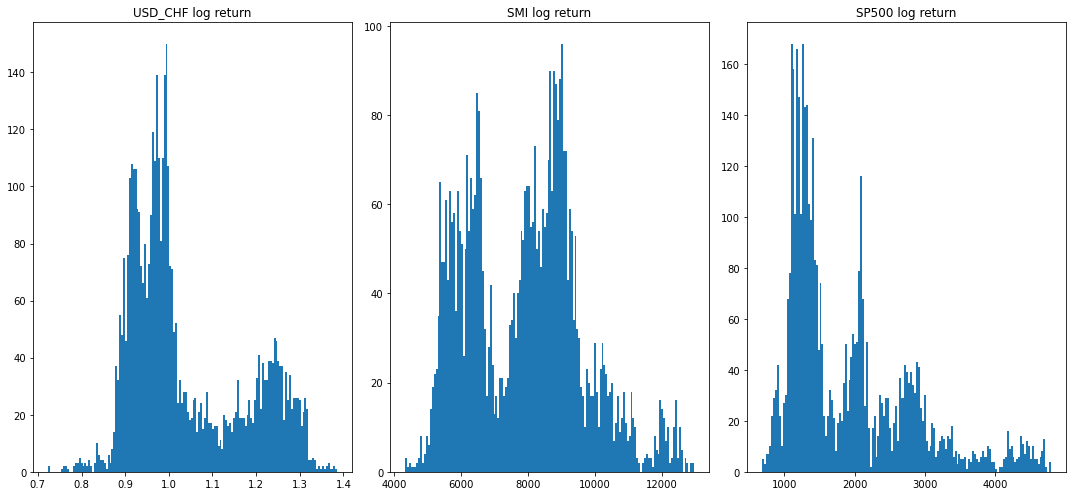

In [ ]:
data = [df.USD_CHF, df.SMI, df.SP500]

fig = plt.figure(figsize=(15, 7))

name  = ['USD_CHF log return','SMI log return', 'SP500 log return']
for i in range(len(data)):   
    plt.subplot(1,len(data),1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

### Scale data (?) rewiev scaling method 

In [ ]:
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=5, norm_=False, fraction_val_=0.2, fraction_test_=0.2)

Shape:             
X train     (2883, 5, 3), y train     (2883, 3)            
X train val (721, 5, 3) , y train val (721, 3)             
X test      (902, 5, 3) , y test      (902, 3)


# Price prediction 

### Dense (ONLY USD_CHF)

In [1]:
model_dense = ml.Dense(num_layers=1, layer_size=8, input_size=5, output_size=1, dropout=0.05)
model_dense

NameError: ignored

In [ ]:
train_loss, val_loss = pl.train(model_dense, train_x[:,:,0], train_y, val_x[:,:,0], val_y, batch_size_= 256, num_epochs_=1000, lr=0.0001, device_='cpu')


 20%|██        | 203/1000 [00:07<00:27, 28.62it/s]

Epoch: 200/1000 MSE = [train :  0.20485523] , [val:  0.19681641]


 40%|████      | 404/1000 [00:14<00:22, 26.29it/s]

Epoch: 400/1000 MSE = [train :  0.04826067] , [val:  0.03464289]


 60%|██████    | 604/1000 [00:21<00:13, 30.12it/s]

Epoch: 600/1000 MSE = [train :  0.02305682] , [val:  0.01932415]


 80%|████████  | 804/1000 [00:28<00:07, 27.51it/s]

Epoch: 800/1000 MSE = [train :  0.00944610] , [val:  0.00832663]


100%|██████████| 1000/1000 [00:34<00:00, 28.65it/s]

Epoch: 1000/1000 MSE = [train :  0.00378722] , [val:  0.00265097]


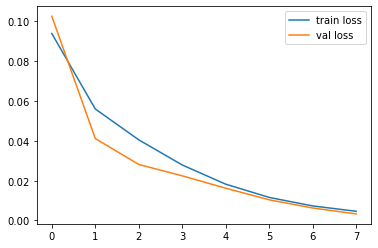

MSE: 0.06658370733318553%
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     8441.
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        13:00:40   Log-Likelihood:                 2705.8
No. Observations:                 902   AIC:                            -5408.
Df Residuals:                     900   BIC:                            -5398.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2678     

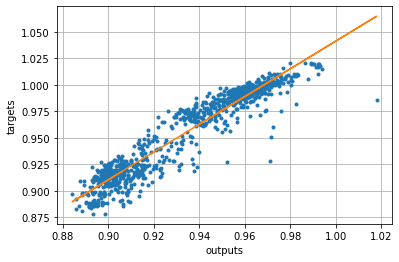

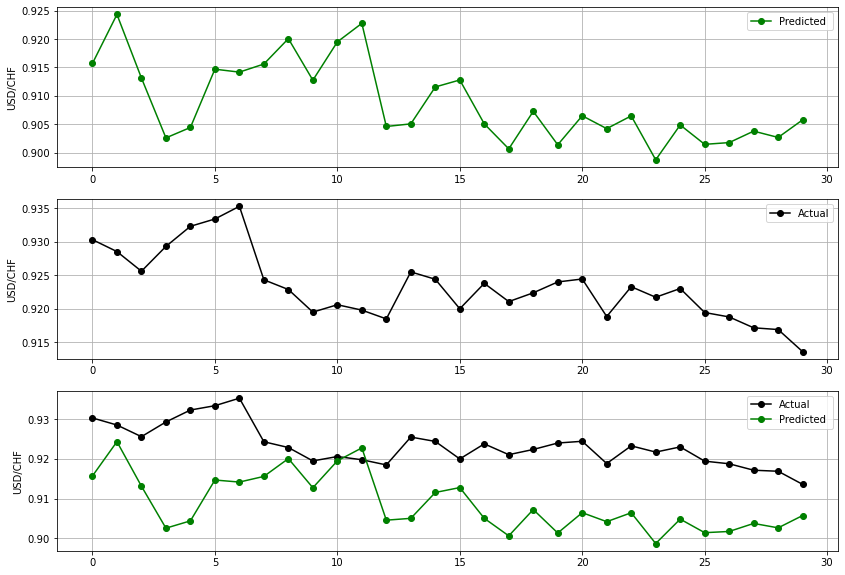

In [ ]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 100)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 100)[1:] , label="val loss")
plt.legend()
plt.show()

outputs, targets, MSE = pl.evaluate(model_dense, test_x[:,:,0], test_y) 
pl.regression_result(targets,outputs)

ds.plot_result_price(outputs, targets, nb=30)

### Dense (ALL features)

In [ ]:
model_dense_all = ml.Dense(num_layers=1, layer_size=8, input_size=15, output_size=1, dropout=0.05)
model_dense_all

Dense(
  (net): Sequential(
    (0): Linear(in_features=15, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.05, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [ ]:
train_loss, val_loss = pl.train(model_dense_all, train_x.reshape(-1, 15), train_y, val_x.reshape(-1, 15), val_y, batch_size_= 256, num_epochs_=1000, lr=0.0001, device_='cpu')


 20%|██        | 204/1000 [00:07<00:36, 21.76it/s]

Epoch: 200/1000 MSE = [train :  1.74106279] , [val:  3.13378804]


 40%|████      | 403/1000 [00:14<00:19, 30.38it/s]

Epoch: 400/1000 MSE = [train :  0.34793642] , [val:  0.51238625]


 60%|██████    | 603/1000 [00:21<00:12, 30.55it/s]

Epoch: 600/1000 MSE = [train :  0.10386384] , [val:  0.48940977]


 81%|████████  | 806/1000 [00:28<00:06, 29.83it/s]

Epoch: 800/1000 MSE = [train :  0.06413699] , [val:  0.79299789]


100%|██████████| 1000/1000 [00:35<00:00, 28.55it/s]

Epoch: 1000/1000 MSE = [train :  0.04210404] , [val:  0.21505386]


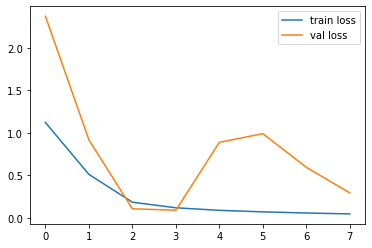

MSE: 0.06658370733318553%
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     8441.
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        13:01:57   Log-Likelihood:                 2705.8
No. Observations:                 902   AIC:                            -5408.
Df Residuals:                     900   BIC:                            -5398.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2678     

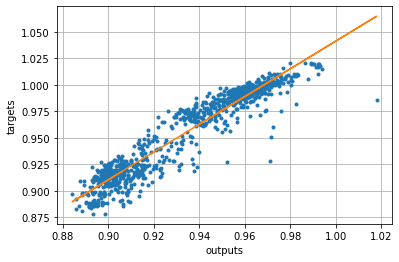

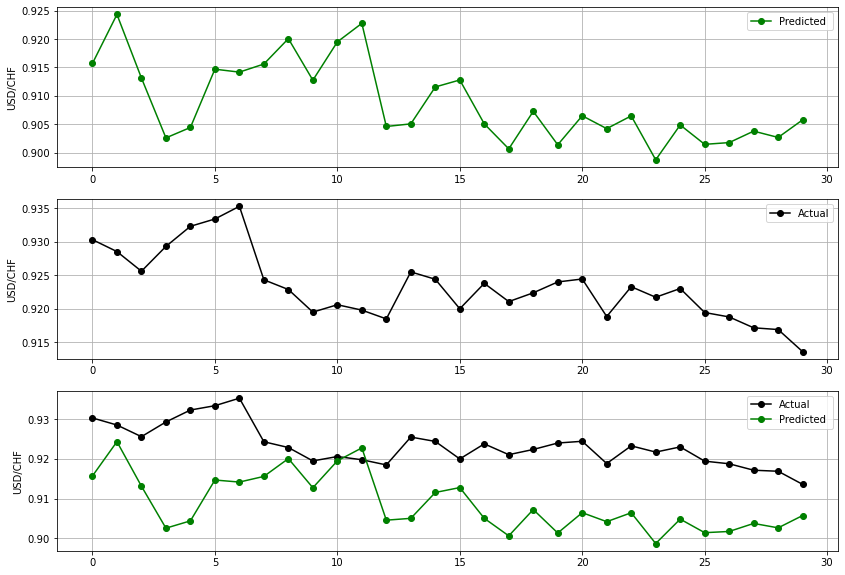

In [ ]:
plt.plot(pl.smooth_loss(train_loss, chunksize = 100)[1:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = 100)[1:] , label="val loss")
plt.legend()
plt.show()

outputs, targets, MSE = pl.evaluate(model_dense, test_x[:,:,0], test_y) 
pl.regression_result(targets,outputs)

ds.plot_result_price(outputs, targets, nb=30)

# Result:
## Dense net (ONLY USD_CHF)
###### [num_layers=1, layer_size=8, input_size=5, output_size=1, dropout=0.05] and [batch_size_= 256, num_epochs_=1000, lr=0.0001]
- MSE = [train :  0.00378722] , [val:  0.00265097]
- MSE: 0.06658370733318553% (Test)
- R-squared: 0.904

###### [ ... ] and [... ]
- MSE = [train :  ... ] , [val: ...]
- MSE: ... % (Test)
- R-squared: ...


## Dense net (ALL features)
###### [num_layers=1, layer_size=8, input_size=15, output_size=1, dropout=0.05] and [batch_size_= 256, num_epochs_=1000, lr=0.0001]
- MSE = [train :  0.04210404] , [val:  0.21505386]
- MSE: 0.06658370733318553% (Test)
- R-squared: 0.904

###### [ ... ] and [... ]
- MSE = [train :  ... ] , [val: ...]
- MSE: ... % (Test)
- R-squared: ...

